# Imports

In [203]:
# from helpers import *
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd  
import random

import os, os.path
from os import listdir

from fastdtw import fastdtw # pip install fastdtw
from itertools import chain

import seaborn as sns




# Helpers

In [204]:
def trim_list_under(lst, upper):
    first = 0
    last = len(lst)-1
    for i in range(0, len(lst)):
        if lst[i] > upper:
            first = i
            break
    for i in range(len(lst)-1, -1, -1):
        if lst[i] > upper:
            last = i
            break

    return lst[first:last+1]

from collections import deque
from bisect import insort, bisect_left
from itertools import islice
def moving_median(seq, window_size):
    """Contributed by Peter Otten"""
    seq = iter(seq)
    d = deque()
    s = []
    result = []
    for item in islice(seq, window_size):
        d.append(item)
        insort(s, item)
        result.append(s[len(d)//2])
    m = window_size // 2
    for item in seq:
        old = d.popleft()
        d.append(item)
        del s[bisect_left(s, old)]
        insort(s, item)
        result.append(s[m])
    # at this point, the 'result' contains the smoothe values, but, the first elements with size 'window_size' are copied from the original list. Therefore, the smoothing is shifted and needs centering
    
    #centering the list
    result=result[window_size-1:len(result)]
    padd = window_size//2
    r1 = [result[0]]*(padd)
    r2=  result 
    r3 =[result[len(result)-1]]*(padd - 1)
    result = r1+r2+r3
    return result


#reads a list of csv files from a directory.
#each csv file contains a pandas dataframe that represents a SUP. The name of the file follows h1_wahser00.csv,..,h1_wahser32.csv
#SUP files are stored in order so that each cluster are adjacent.
#SUP files are stored in a directory named with the appliance name
def read_SUPs(house,appliance):
    path = f'house{house}/{appliance}'
    files=[f for f in os.listdir(path)if os.path.isfile(os.path.join(path, f))]
    num_files = len(files)

    SUPs=[]
    for i in range(0,num_files):
        try:
            SUPs.append(  pd.read_csv(f'house{house}/{appliance}/h{house}_{appliance}{i:02d}.csv'))
        except:
            pass
    return SUPs

# Clustering

In [205]:
def check_core_point(eps,minPts, df, index,DTW):#sups):
    #get points from given index
    # sup = df.iloc[index]

    #check available points within radius
    nebors=np.ones((len(df)), dtype=bool)
    for i in range(len(df)):
        norm_distance = DTW[index][i]
        if norm_distance <= eps and i != index:
            nebors[i]= True
        else:
            nebors[i]= False
    nebors = df[nebors]
    
    #check how many points are present within radius
    if len(nebors) >= minPts:
        #return format (dataframe, is_core, is_border, is_noise)
        return (nebors.index , True, False, False)
    
    elif (len(nebors) < minPts) and len(nebors) > 0:
        #return format (dataframe, is_core, is_border, is_noise)
        return (nebors.index , False, True, False)
    
    elif len(nebors) == 0:
        #return format (dataframe, is_core, is_border, is_noise)
        return (nebors.index , False, False, True)



def cluster_with_stack(eps, minPts, df, DTW):#sups):
    
    #initiating cluster number
    C = 1
    #initiating stacks to maintain
    current_stack = set()
    unvisited = list(df.index)
    clusters = []
    
    
    while (len(unvisited) != 0): #run until all points have been visited

        #identifier for first point of a cluster
        first_point = True
        
        #choose a random unvisited point
        current_stack.add(random.choice(unvisited))
        
        while len(current_stack) != 0: #run until a cluster is complete
            
            #pop current point from stack
            curr_idx = current_stack.pop()
            
            #check if point is core, neighbour or border
            neigh_indexes, iscore, isborder, isnoise = check_core_point(eps, minPts, df, curr_idx, DTW)
            
            #dealing with an edge case
            if (isborder & first_point):
                #for first border point, we label it aand its neighbours as noise 
                clusters.append((curr_idx, 0))
                clusters.extend(list(zip(neigh_indexes,[0 for _ in range(len(neigh_indexes))])))
                
                #label as visited
                unvisited.remove(curr_idx)
                unvisited = [e for e in unvisited if e not in neigh_indexes]
    
                continue
                
            unvisited.remove(curr_idx) #remove point from unvisited list
            
            
            neigh_indexes = set(neigh_indexes) & set(unvisited) #look at only unvisited points
            
            if iscore: #if current point is a core
                first_point = False
                
                clusters.append((curr_idx,C)) #assign to a cluster
                current_stack.update(neigh_indexes) #add neighbours to a stack

            elif isborder: #if current point is a border point
                clusters.append((curr_idx,C))
                
                continue

            elif isnoise: #if current point is noise
                clusters.append((curr_idx, 0))
                
                continue
                
        if not first_point:
            #increment cluster number
            C+=1
        
    return clusters

# Silhouett Score

In [206]:
def silo(cluster_df, sups,cluster_no,DTW):

    #members of the #cluster_no
    cluster = cluster_df[cluster_df["cluster"]==cluster_no]

    #members of all other clusters excluding outliers --> cluser=0
    others = cluster_df[(cluster_df.idx.isin(cluster.idx) == False) & (cluster_df["cluster"]!=0)]
    #    cluster_df = cluster  UNION others

    total_score=0
    for i in range(len(cluster)):

        index=cluster["idx"].iloc[i]
        supi=sups[index]

        #total distance between supi and other sups within the cluster
        dist_within_clust=0
        for idx in cluster["idx"]:
            if idx != index:# exclude the distance between sup1 and itself
                # distance,pat=fastdtw(supi, sups[idx])
                norm_distance = DTW[index][idx]
                dist_within_clust=dist_within_clust + norm_distance

        #total distance between supi and other sups within the other clusters
        dist_with_others_clust=0
        for idx in others["idx"]:
            # distance,pat=fastdtw(supi, sups[idx])
            norm_distance = DTW[index][idx]
            dist_with_others_clust=dist_with_others_clust + norm_distance       
        
        total_score+=(dist_with_others_clust - dist_within_clust)/ max(dist_with_others_clust , dist_within_clust)
    
    
    return total_score/len(cluster)


# RAE

In [207]:

appliance='dishwasher'
house='1'
trim_below=50
window_size=50


dfSUPs = read_SUPs(house,appliance)
SUPs=[]
for i in range(0,len(dfSUPs)):
    seg = dfSUPs[i][f'{appliance}'].values.tolist()
    trimmed = trim_list_under(seg,trim_below)
    SUPs.append(trimmed)
print(len(SUPs))


33


# UK-DALE

In [197]:

# # f = open("uk-dale//house2//wm.dat", "r")
# # points = [
# #     0, 76000, 77000, 77900, 78400, 79000, 92000, 175165, 176000, 260000, 274750, 315000, 356000, 360000, 380000, 460000, 468500, 469000, 560000, 580000, 652000, 653000, 654000, 656000, 751700, 752500, 754000, 835206, 836000, 891000, 908000, 948000, 949100, 950000, 963700, 965000, 1019000, 1020000, 1046000, 1062000, 1074225, 1074740, 1075500, 1142500, 1190000, 1239625, 1245000, 1323500, 1324250, 1425000, 1440000, 1520250, 1521000, 1534000, 1536250, 1622000, 1633953, 1634600, 1664000
# # ]

# f = open("uk-dale//house2//dw.dat", "r")
# points = [
#     0, 20000, 30000, 50000, 70000, 80000, 90000, 100000, 120000, 130000, 140000, 160000, 170000, 190000, 200000, 210000, 230000, 240000, 260000, 270000, 280000, 300000, 320000, 330000, 340000, 350000, 380000, 400000, 420000, 440000, 450000, 460000, 500000, 510000, 520000, 540000, 570000, 580000, 600000, 620000, 640000, 650000, 680000, 690000, 710000, 720000, 740000, 770000, 780000, 790000, 810000, 830000, 860000, 880000, 890000, 920000, 930000, 960000, 980000, 990000, 1000000, 1010000, 1020000, 1030000, 1050000, 1060000, 1070000, 1090000, 1110000, 1120000, 1130000, 1140000, 1150000, 1170000, 1180000, 1200000, 1210000, 1220000, 1240000, 1250000, 1270000, 1280000, 1290000, 1310000, 1320000, 1330000, 1370000, 1380000, 1390000, 1410000, 1430000, 1450000, 1460000, 1480000, 1490000, 1500000, 1520000, 1560000, 1580000, 1590000, 1600000, 1624500, 1630000, 1650000, 1660000, 1670000, 1684800]



# trim_below=50
# window_size=20



# data = []
# SUPs = []
# for x in f:
#     data.append(int(x.split(" ")[1]))


# smoothedData = moving_median(data, window_size)
# data = smoothedData

# segs=[]
# for i in range(len(points)-1):
#     seg = data[points[i]:points[i+1]]
#     segs.append(seg)
#     sup = trim_list_under(seg, trim_below)
#     if len(sup)>150:
#         SUPs.append(sup)
# # print(len(SUPs))
# # plt.plot(SUPs[1])
# # plt.savefig(f'eps/last.png', format='png')
# # plt.show()
# f.close()



# Smooth, Normalize, DTW matrix

In [208]:
smoothedSUPs=[]
for i in range(0,len(SUPs)):
    smoothed = moving_median(SUPs[i], window_size)
    smoothedSUPs.append(smoothed)

#normalization to 0-1
allSUPs = list(chain.from_iterable(smoothedSUPs))
PowMax= max(allSUPs )
PowMin= min(allSUPs )
diff=PowMax -PowMin
for i in range(len(smoothedSUPs)):
    for j in range(len(smoothedSUPs[i])):
        smoothedSUPs[i][j]= (smoothedSUPs[i][j]-PowMin)/diff

#compute DTW matrix
DTW=[]
for i in range(len(smoothedSUPs)):
    row=[]
    for j in range(len(smoothedSUPs)):
        dist, path =fastdtw(smoothedSUPs[i],smoothedSUPs[j])
        norm_distance = dist/(len(smoothedSUPs[i])+ len(smoothedSUPs[j]))
        row.append(norm_distance)
    DTW.append(row)




# Main

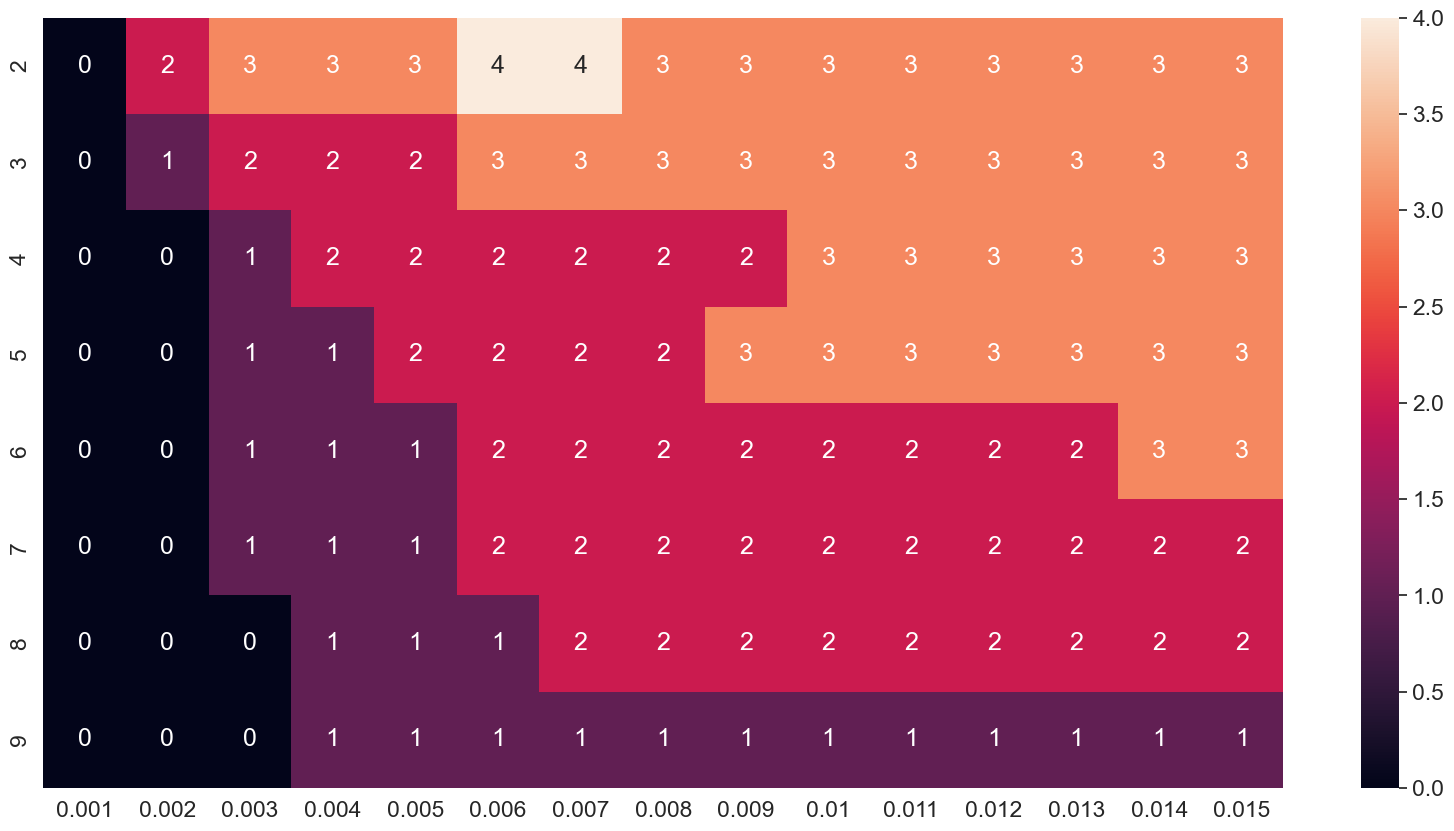

In [199]:

sups = smoothedSUPs
# data = pd.DataFrame(X, columns = ["X", "Y"] )
data = pd.DataFrame(sups)
numClusters=[]
siloScores=[]
x_lbl=[]
y_lbl=[]

# Number of neighbours loop
for j in range(2,10):
    minPts=j
    rowNumClusters=[]
    rowSiloScores=[]
    x_lbl=[]
    y_lbl.append(j)
    # Epsilon loop
    for i in range(1,16,1):

        eps=i/1000
        x_lbl.append(eps)
       





        clustered = cluster_with_stack(eps, minPts, data, DTW)
        cluster_df = pd.DataFrame(clustered, columns = ["idx", "cluster"])

        idx , cluster = list(zip(*clustered))
       
        if max(cluster)>10:
            rowNumClusters.append(0)
        else:
            rowNumClusters.append(max(cluster))






        avg_silo_all_clusters=0
        num_clusters = max(cluster)
        error=0
        for k in range(1, 1+num_clusters):
            try:
                silh=silo(cluster_df, sups,k,DTW)
                avg_silo_all_clusters+=silh
            except:
                avg_silo_all_clusters+=0
                error+=1
        try:
            rowSiloScores.append(avg_silo_all_clusters/(num_clusters-error))
        except:
            rowSiloScores.append(-1)

       


    siloScores.append(rowSiloScores)    
    numClusters.append(rowNumClusters)

cluster_df = pd.DataFrame(clustered, columns = ["idx", "cluster"])

plt.rcParams['figure.figsize'] = (20, 10)
sns.set(font_scale=1.5)
ax = sns.heatmap(numClusters,xticklabels=x_lbl,yticklabels=y_lbl, annot=True)




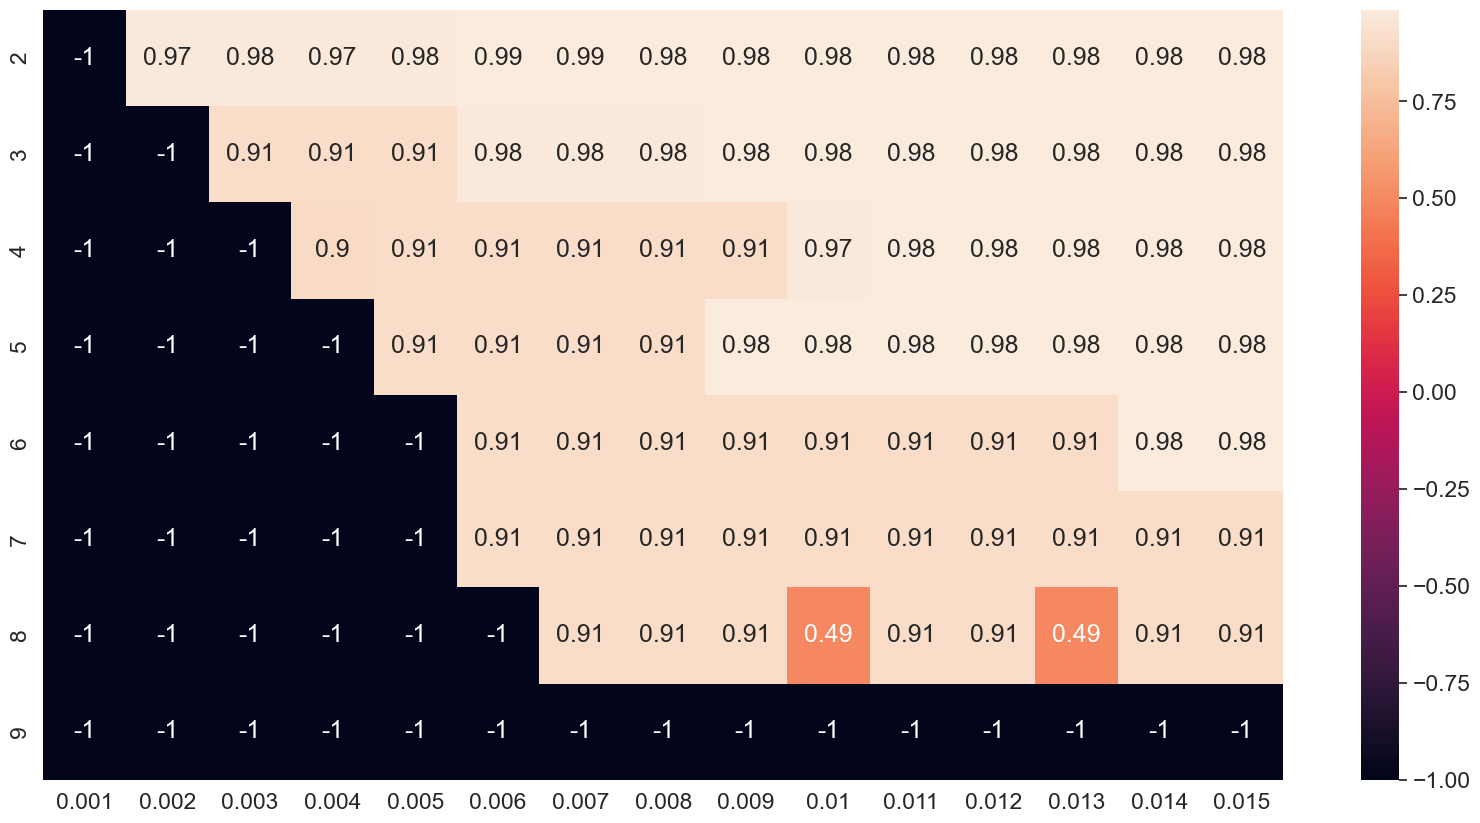

In [200]:
plt.rcParams['figure.figsize'] = (20, 10)
sns.set(font_scale=1.5)
ax2 = sns.heatmap(siloScores,xticklabels=x_lbl,yticklabels=y_lbl, annot=True)
# ax.figure.savefig("eps/heat.eps",dpi=300)

In [201]:
clustered = cluster_with_stack(.003,2, data, DTW)
cluster_df = pd.DataFrame(clustered, columns = ["idx", "cluster"])

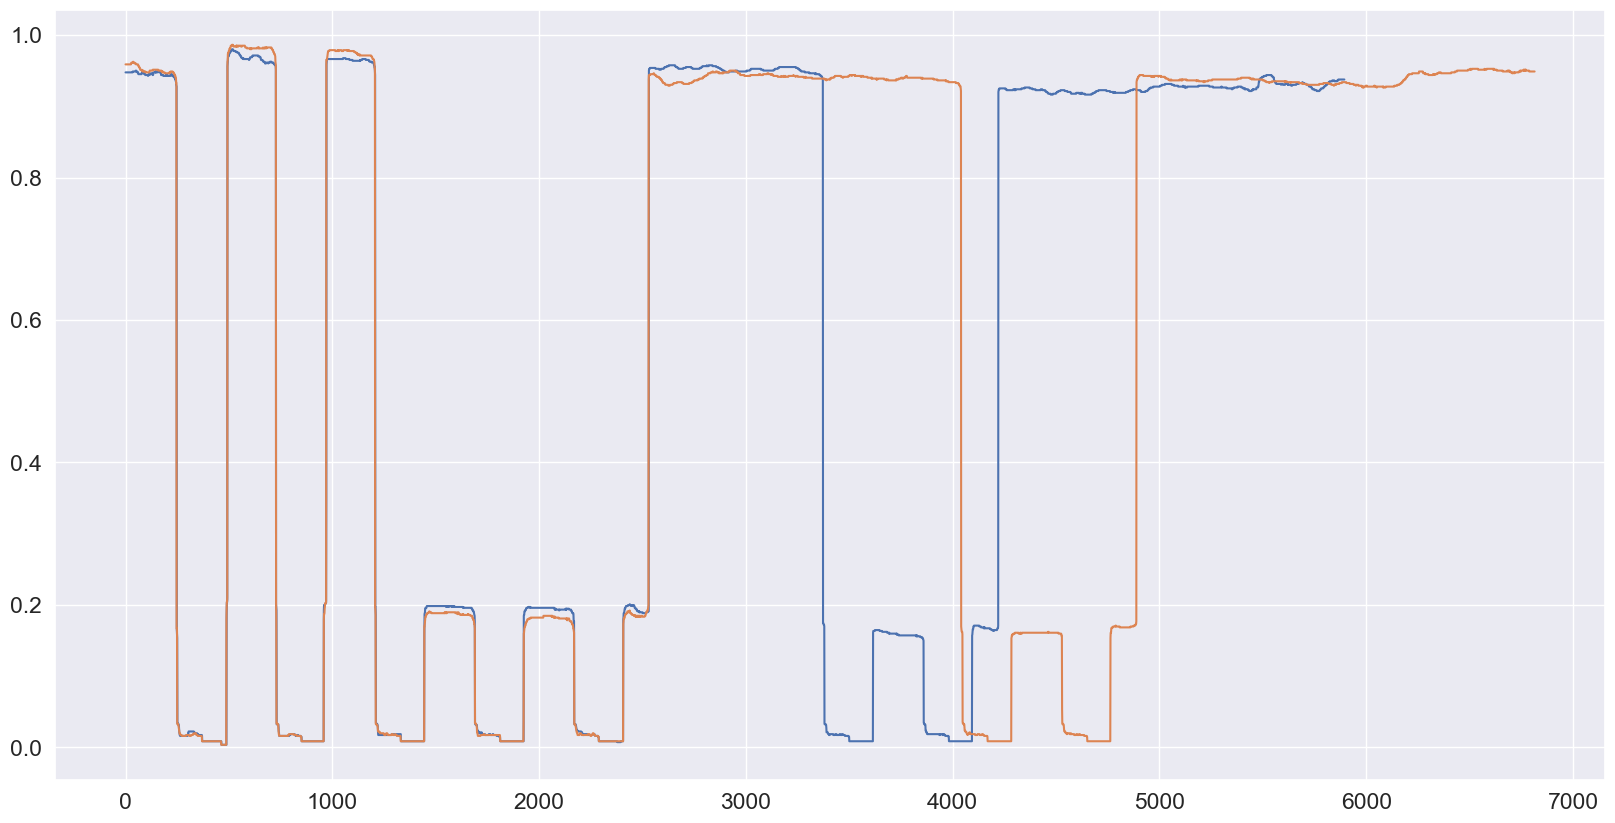

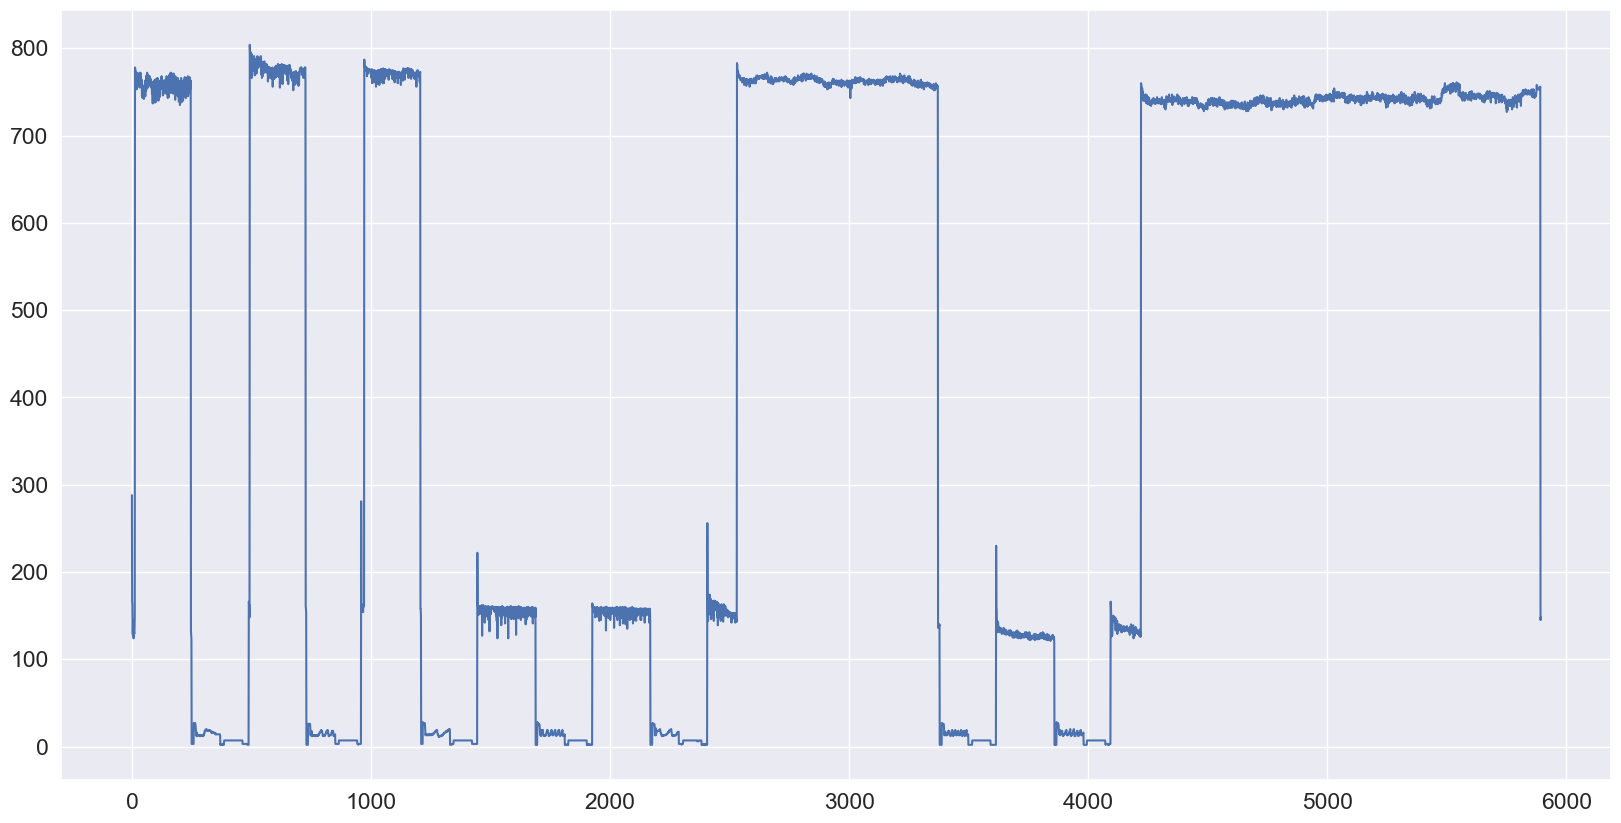

In [212]:
plt.plot(smoothedSUPs[9])
plt.plot(smoothedSUPs[10])
plt.show()

# plt.plot(segs[9])
plt.plot(SUPs[9])
plt.savefig(f'sup.eps', format='eps')
plt.show()

